<div style="text-align: right">
    <h1> Assignment 1 </h1>
    <h1> Bhavi Dhingra </h1>
    <h1> 2018201058 </h1>
</div>

## Lucas-Kanade Optical flow

Optical Flow tries to estimate the movement present in a scene captured as a sequence of Image. In this implementation we estimage the optical flow at subsequent intervals (location) in an image between two pairs of image at a single scale. This essentially boils down to finding two displacements in the $x$ and $y$ directions, between two subsequent images. The general algorithm for lucas kanade takes into consideration a window of pixels around a given pixel and tries to find the displacement in the window by comparing it with the similar window in the next Image. It works on the assumtion that there is small movements between successive frames of the image and brightness consistency holds at all pixels in the window. Under these circumstances we can find the velocity vector$(V_x,V_y)$ in x and y as follows. 

If $V_x = \dfrac{dx}{dt}$ and $V_y = \dfrac{dy}{dt}$ we can write $I(x,y,t) = I(x+dx,y+dy,t+dt)$. By taylors series expansion of the RHS we arrive at the form $$I_xV_x + I_yV_y = -I_t$$ where $I_x$ and $I_y$ are the gradients of the image at $x$ and $y$ directions. Let $q_1,q_2,q_3...q_n$ form the set of pixels in the neighbourhood of pixel $(x,y)$. Then we can open up the previous equation and write it in a matrix product form. 

$$\begin{bmatrix}
     I_{x}(q_{1}) & I_{y}(q_{1}) \\ 
     I_{x}(q_{2}) & I_{y}(q_{2}) \\
     \vdots & \vdots \\
     I_{x}(q_{n}) & I_{y}(q_{n})
 \end{bmatrix}
 \begin{bmatrix}
     V_{x} \\
     V_{y}
 \end{bmatrix} = 
 \begin{bmatrix}
     -I_{t}(q_{1}) \\ 
     -I_{t}(q_{2}) \\
     \vdots \\
     -I_{t}(q_{n})
 \end{bmatrix} \\
 Av = b
$$

Here we have again assumed that all the pixels in the neighbourhood move by the same amount $V_x,V_y$. Now, this is a over determined system of equations hence we need to find a least square solution to the problem. 
 $$v = (A^TA)^{-1}A^Tb$$
 In matrix form this becomes 
 $$\begin{bmatrix} V_{x} \\ V_{y} \end{bmatrix} = \begin{bmatrix} \sum _{i}I_{x}(q_{i})^{2} & \sum _{i}I_{x}(q_{i})I_{y}(q_{i}) \\ \sum _{i}I_{y}(q_{i})I_{x}(q_{i}) & \sum _{i}I_{y}(q_{i})^{2} \end{bmatrix}^{{-1}} \begin{bmatrix} -\sum _{i}I_{x}(q_{i})I_{t}(q_{i}) \\ -\sum _{i}I_{y}(q_{i})I_{t}(q_{i}) \end{bmatrix}$$ <br>
 The $A^TA$ matrix is the 2nd moment matrix

In [1]:
import warnings
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
warnings.filterwarnings('ignore')
eps = np.finfo(float).eps

In [2]:
import ipdb

In [3]:
def showImage(imageSet, figsize=(6,5)):
    plt.figure(figsize=figsize)
    for i,image in enumerate(imageSet):
        plt.subplot(1,len(imageSet),i+1)
        plt.imshow(image, cmap='gray')
    plt.show()

### Getting the Intensity Derivatives in the x and y directions

Getting the intensity derivatives in the x and y direction is done by subtracting the neighbouring pixels at (x,y) and averaging the difference i.e. $$grad_x(x,y) = \dfrac{I_{(x+1,y)} - I_{(x-1,y)}}{2}$$ and similarly $$grad_y(x,y) = \dfrac{I_{(x,y+1)} - I_{(x,y-1)}}{2}$$ where $I_{(x,y)}$ is the intensity at pixel $(x,y)$

In [4]:
def getIxIy(img):
    auxImg = np.hstack((np.zeros([img.shape[0],1]), img, np.zeros([img.shape[0],1])))
    Ix = (auxImg[:, 2:] - auxImg[:, :-2]) / 2

    auxImg  = np.vstack((np.zeros([1, img.shape[1]]), img, np.zeros([1, img.shape[1]])))
    Iy = (auxImg[2:, :] - auxImg[:-2, :]) / 2
    return Ix, Iy

def getIt(img1, img2):
    return img1 - img2

### Finding the velocity vectors in x and y directions

In this function we actually find the velocty vector by performing the computations stated above. Given is the intensity deivatives in $x$ and $y$ direction, and the derivative w.r.t t, two images, the starting position, the kernel size (window) which is usually 15x15 or 31x31 as well some thresholding to limit the displacement magnitude in the output. It also returns the magitude of calculated velocity vector and the orientation in the image. Magitude and directions are only used for image segmentation purposes.

In [5]:
def computeVelocities(Ix, Iy, It, grayImg1, grayImg2, startpos, kernel, max_displacement = 3):
    y, x = startpos

    window = ((max(0, x - int(kernel/2)), max(0, y - int(kernel/2))),\
              (min(grayImg1.shape[0], x + int(kernel/2)), min(grayImg1.shape[1], y + int(kernel/2))))

    Ix = Ix[window[0][0] : window[1][0] + 1, window[0][1] : window[1][1] + 1].reshape(-1,1)
    Iy = Iy[window[0][0] : window[1][0] + 1, window[0][1] : window[1][1] + 1].reshape(-1,1)
    It = It[window[0][0] : window[1][0] + 1, window[0][1] : window[1][1] + 1].reshape(-1,1)
    
    A = np.hstack((Ix, Iy))

    try:
        mInv = np.linalg.inv(A.T.dot(A))   # inverse of the second moment matrix A'A
    except:
        return startpos, 0, 0              # 2nd moment matrix is singular
    
    u, v = -1 * mInv.dot(A.T.dot(It))
    
    # reduce the displacement amount 
    # (only used to make the dense image more understandable with smaller lines)
    u1 = np.sign(u) * min(np.abs(u), max_displacement)
    v1 = np.sign(v) * min(np.abs(v), max_displacement)
    
    new_point = (int(y + u1), int(x + v1))
    magnitude = (u[0]**2 + v[0]**2)**0.5
    direction = np.round(np.arctan2(v[0], u[0]) * (180 / np.pi))
    
    return new_point, magnitude, direction

### Finding the optical flow

 The optical flow is calculated by going through the image calculating the velocity vector at every interval point in the image. The resultant displacements are plotted as arrowed lines from the starting position.

In [6]:
def opticalFlow(img1, img2, kernel, stride = 10, max_displacement = 3, thickness = 1):
    grayImg1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    grayImg2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    pad = int(kernel/2)
    centers = [[], []]
    for i in range(pad, grayImg1.shape[0] - pad, stride):
        for j in range(pad, grayImg1.shape[1] - pad, stride):
            centers[0] += [j]
            centers[1] += [i]

    magnImg = np.zeros(grayImg1.shape,dtype = np.float64)      # magnitude of displacements of each pixel
    dirnImg = np.zeros(grayImg1.shape)                         # direction at each point
    Ix, Iy = getIxIy(grayImg1)
    It = getIt(grayImg1, grayImg2)

    flowImg = img1.copy()
    for c in range(len(centers[0])):
        old_point = (centers[0][c], centers[1][c])
        new_point, magnitude, direction = computeVelocities(Ix, Iy, It, grayImg1, grayImg2, old_point,\
                                                           kernel, max_displacement = max_displacement)
        magnImg[centers[1][c], centers[0][c]] = magnitude
        dirnImg[centers[1][c], centers[0][c]] = direction
        flowImg = cv2.arrowedLine(flowImg, old_point, new_point, (0,255,0), thickness)
    
    return flowImg, magnImg, dirnImg

## Results

### Optical Flow

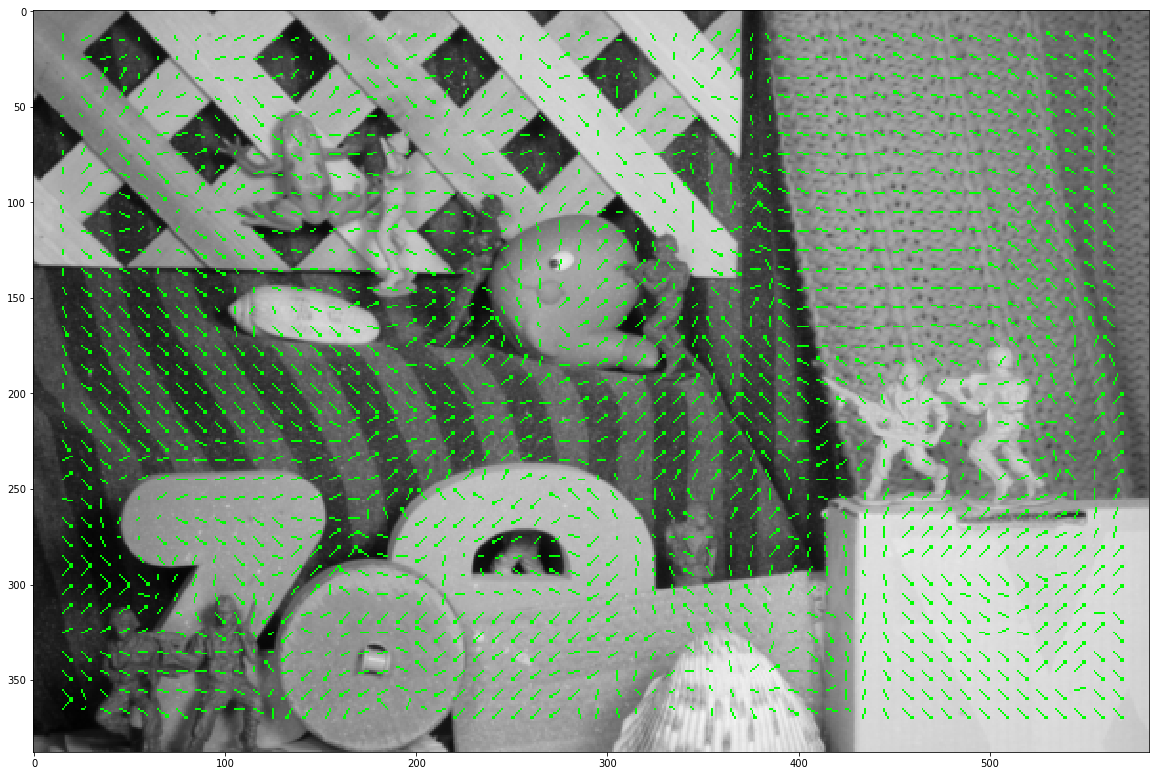

In [59]:
imagesDir = '../eval-data-gray/Army/'
img1Path = imagesDir + 'frame10.png'
img2Path = imagesDir + 'frame11.png'
img1 = cv2.cvtColor(cv2.imread(img1Path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2Path), cv2.COLOR_BGR2RGB)
flowImg1, _, _ = opticalFlow(img1, img2, kernel = 31, stride = 10, max_displacement = 5)
showImage([flowImg1], figsize = (20,20))

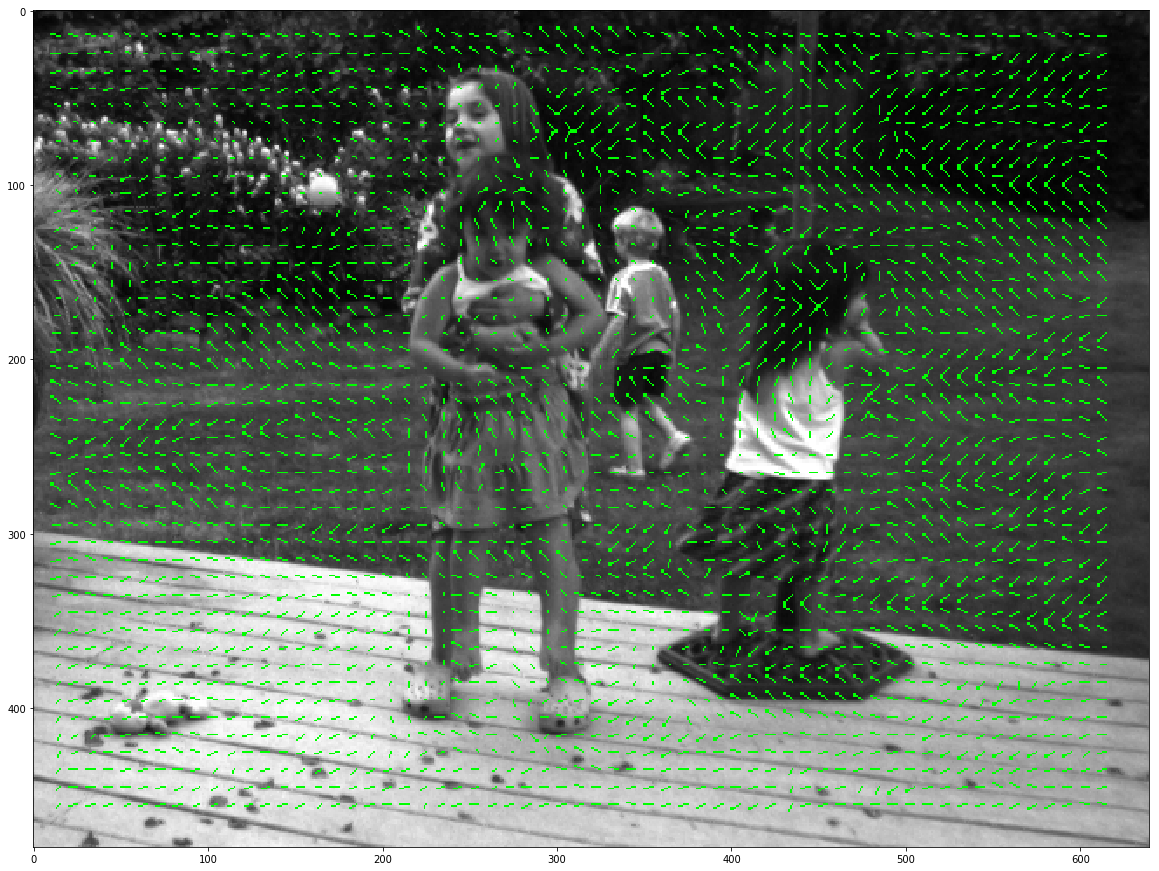

In [60]:
imagesDir = '../eval-data-gray/Backyard/'
img1Path = imagesDir + 'frame10.png'
img2Path = imagesDir + 'frame11.png'
img1 = cv2.cvtColor(cv2.imread(img1Path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2Path), cv2.COLOR_BGR2RGB)
flowImg2, _, _ = opticalFlow(img1, img2, kernel = 31, stride = 10, max_displacement = 5)
showImage([flowImg2], figsize = (20,20))

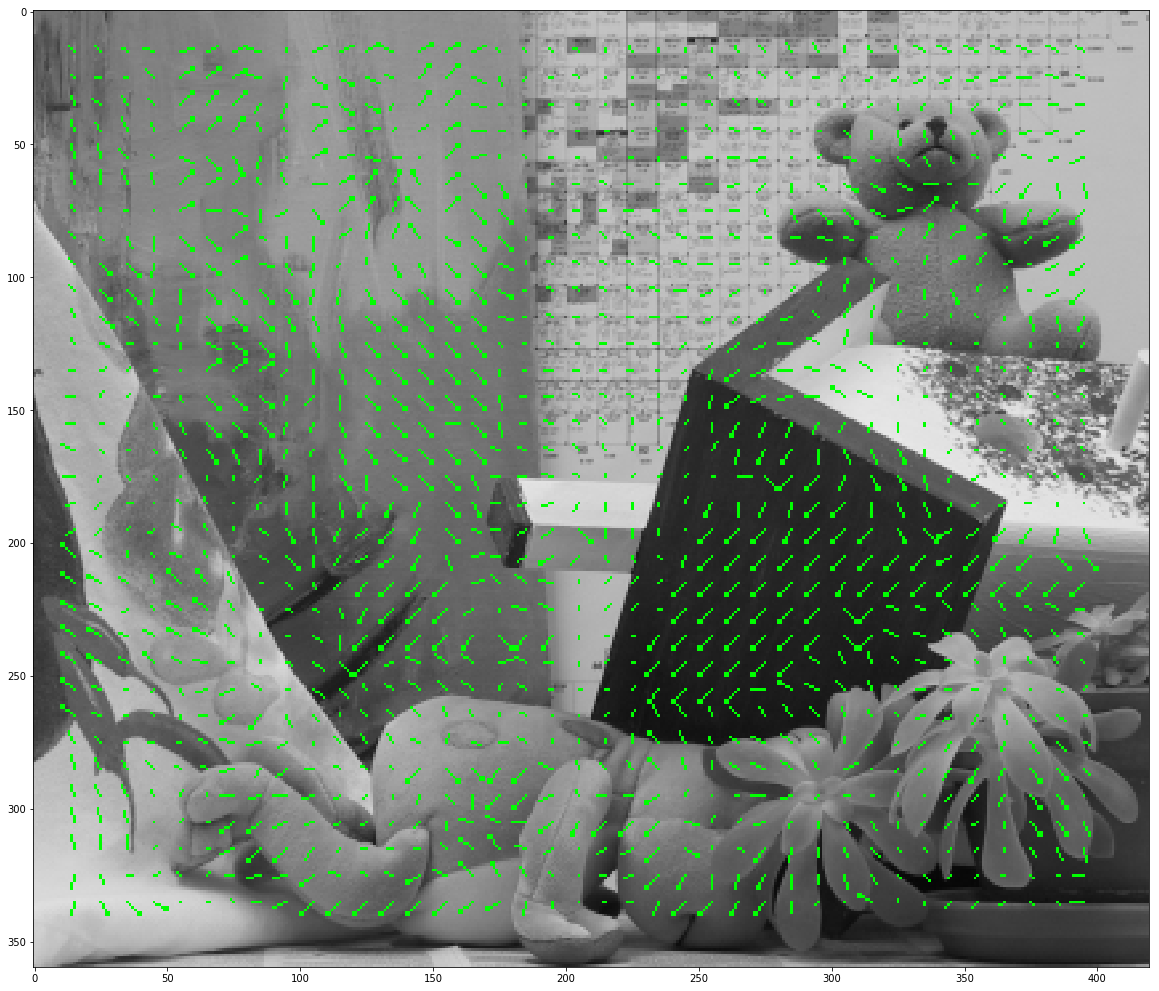

In [61]:
imagesDir = '../eval-data-gray/Teddy/'
img1Path = imagesDir + 'frame10.png'
img2Path = imagesDir + 'frame11.png'
img1 = cv2.cvtColor(cv2.imread(img1Path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2Path), cv2.COLOR_BGR2RGB)
flowImg3, _, _ = opticalFlow(img1, img2, kernel = 31, stride = 10, max_displacement = 5)
showImage([flowImg3], figsize = (20,20))

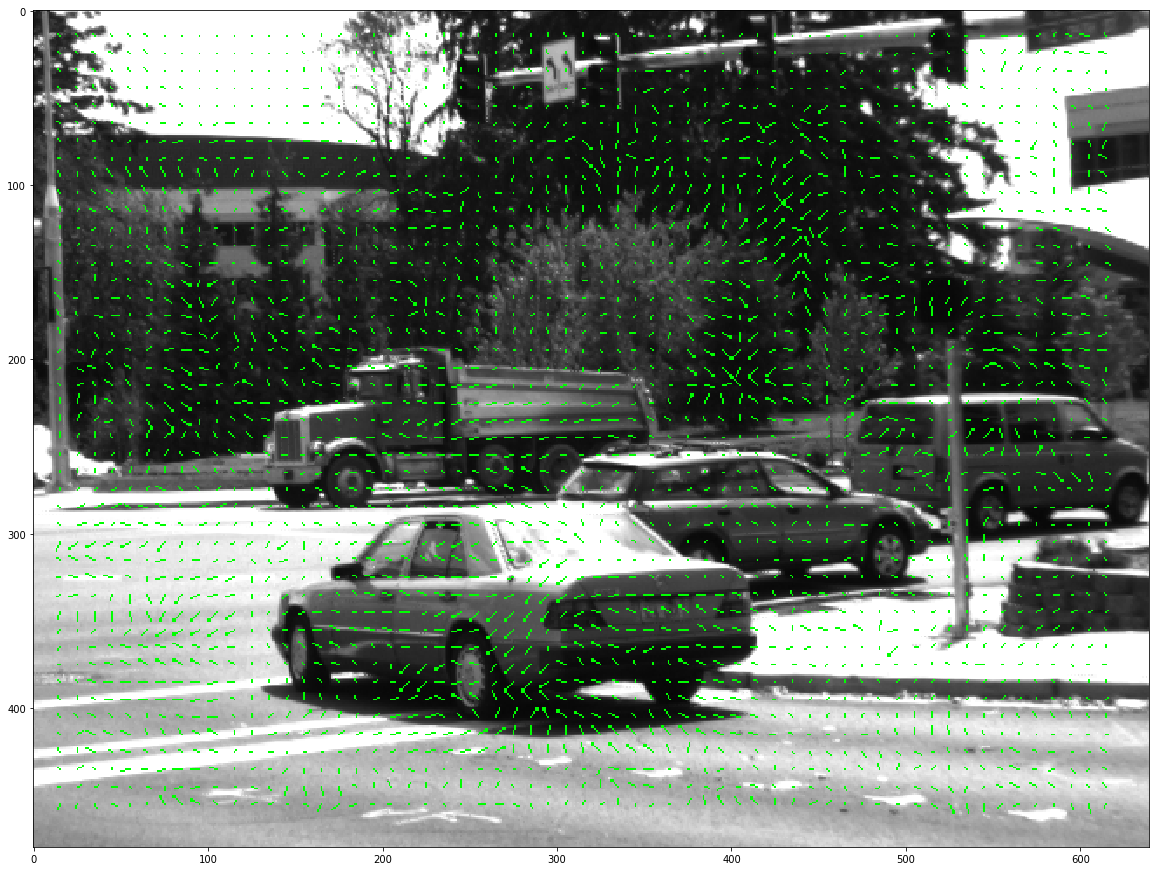

In [62]:
imagesDir = '../eval-data-gray/Dumptruck/'
img1Path = imagesDir + 'frame10.png'
img2Path = imagesDir + 'frame11.png'
img1 = cv2.cvtColor(cv2.imread(img1Path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2Path), cv2.COLOR_BGR2RGB)
flowImg4, _, _ = opticalFlow(img1, img2, kernel = 31, stride = 10, max_displacement = 5)
showImage([flowImg4], figsize = (20,20))

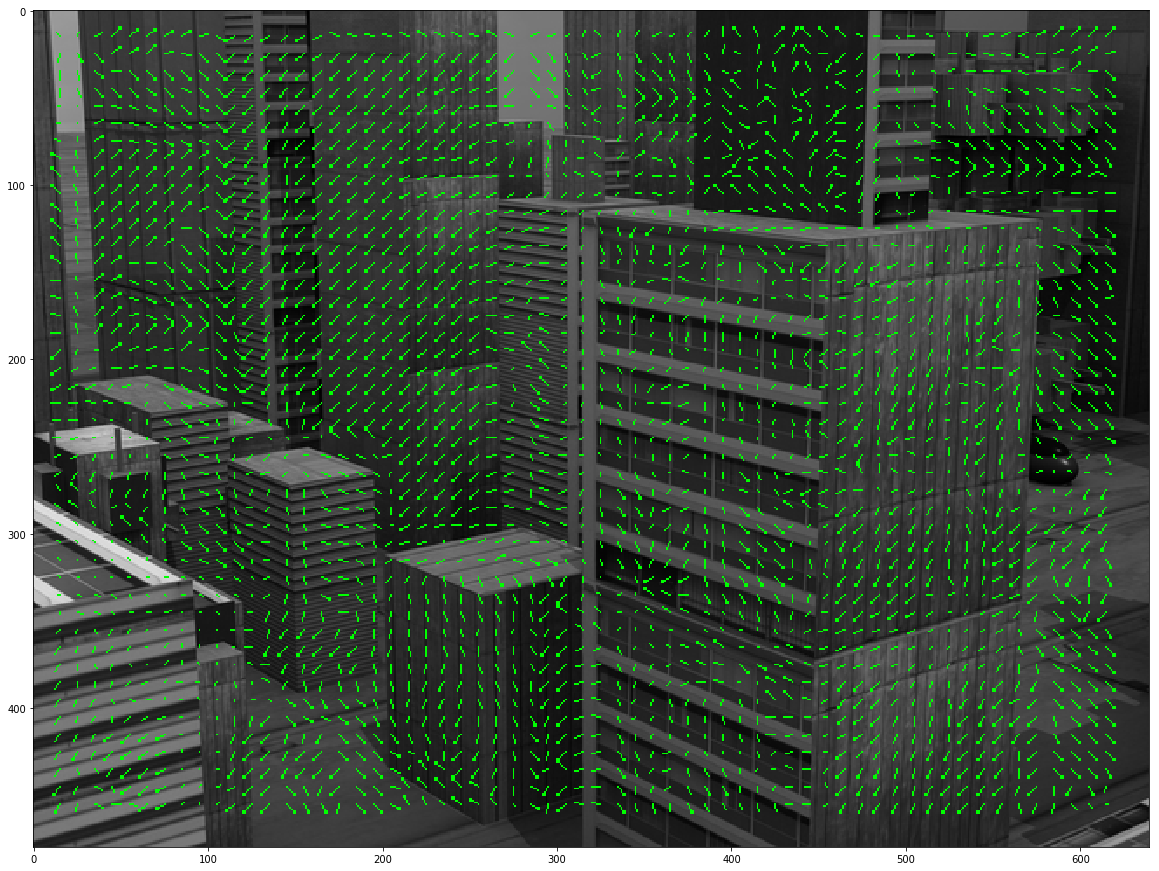

In [63]:
imagesDir = '../eval-data-gray/Urban/'
img1Path = imagesDir + 'frame10.png'
img2Path = imagesDir + 'frame11.png'
img1 = cv2.cvtColor(cv2.imread(img1Path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2Path), cv2.COLOR_BGR2RGB)
flowImg5, _, _ = opticalFlow(img1, img2, kernel = 31, stride = 10, max_displacement = 5)
showImage([flowImg5], figsize = (20,20))

### Object Detection and Visualization
 
To detect objects based on their optical flow we try to find bounding boxes for regions of image that have similar flow magnitude and orientation. For every point $(x,y)$ find a neighbourhood around it that have flow similar to it. If the bounding box found is too large or too small based on some input threshold ignore it. Otherwise the neighbourhood is approximated as a bounding box and labelled as an object. 
Overlapping bounding boxes are merged into one to give a cleaner appearance.
In order for multiple regions of the image to be detected for objects we have to perform object detection at multiple scales by resizing the image.

We find a bounding box around a pixel by iterating horizontally and vertically around the decision point. At every point we check if the magnitude of flow is close to the original point by a threshold theta. We similarly check if the angle of orientation is within a threshold value. However both these metrics are prone to failure in places where different parts of an object move at different velocities or move by different angles. This is somwhat mitigated by using different scales of the image. Since lucas kanade makes the implicit assumtion that the differences in object motion is minor between two frames we expect the variations to be minimal.

In [49]:
# finds a bounding box around a pixel
def getBoundingBox(magImg, dirImg, pos, mth, orth, stride=1):
    c, r = pos
    u,l = [c,r], [c,r]
    iInt, iDir = magImg[r][c], dirImg[r][c]
    if iInt == 0:
        return u, l
    
    # [Upper left corner]
    # find similar points above
    i = 0
    while r - i >=0:
        if magImg[r-i][c] == 0 or abs(magImg[r-i][c] - iInt) > mth or abs(dirImg[r-i][c] - iDir) > orth:
            break
        i += stride
    u[1] -= i
    
    i = 0
    # find similar points to the left
    while c - i >=0:
        if magImg[r][c-i] == 0 or abs(magImg[r][c-i] - iInt) > mth or abs(dirImg[r][c-i] - iDir) > orth:
            break
        i += stride
    u[0] -= i

    i = 0
    # [Lower right corner]
    # find similar points below
    while r + i < magImg.shape[0]:
        if magImg[r+i][c] == 0 or abs(magImg[r+i][c] - iInt) > mth or abs(dirImg[r+i][c] - iDir) > orth:
            break
        i += stride
    l[1] += i
    
    i = 0
    # find similar points to the right
    while c + i < magImg.shape[1]:
        if magImg[r][c+i] == 0 or abs(magImg[r][c+i] - iInt) > mth or abs(dirImg[r][c+i] - iDir) > orth:
            break
        i += stride
    l[0] += i
    
    return u, l

In [111]:
def mergeRectangles(rects):
    if not len(rects):
        return []
    rects = sorted(rects)
    res_rects = [rects[0]]
    i = 1
    while (i < len(rects)):
        t1h, t1c, b1h, b1c = tuple(res_rects[-1])
        t2h, t2c, b2h, b2c = tuple(rects[i])
        if (b1c <= t2c or b1h <= t2h):
            res_rects.append(rects[i])
        else:
            res_rects[-1][2] = max(b1h, b2h)
            res_rects[-1][3] = max(b1c, b2c)
        i += 1
    return res_rects
    
def detectObjects(imageSet, kernel, mth = 4, orth = 180, scale = 1, minw = None, minh = None, maxsc = 0.25):    
    imageScaled = [cv2.resize(image,None,fx=scale,fy=scale) for image in imageSet]
    stride = 5
    pimg, mImg, dImg = opticalFlow(imageScaled[0], imageScaled[1], kernel, stride, 20)

    # bounds to eliminate bounding boxes that are too small
    H, W, _ = imageScaled[0].shape
    if minw == None:
        minw = imageScaled[0].shape[1] * 0.1
    if minh == None:
        minh = imageScaled[0].shape[0] * 0.1

    # bounds to eliminate bounding boxes that are too large
    maxw, maxh = imageScaled[0].shape[1] * maxsc, imageScaled[0].shape[0] * maxsc

    resImg = np.zeros(imageScaled[0].shape,dtype = np.uint8)
    pad =int(kernel/2)
    i,j = pad,pad
    bboxes = []
    while i < (imageScaled[0].shape[0]-pad):
        mxDisp = 1
        while j < (imageScaled[1].shape[1]-pad):
            u, l = getBoundingBox(mImg, dImg, (j,i), mth, orth, stride)
            if abs(u[0] - l[0]) > minw and abs(u[0] - l[0]) < maxw and abs(u[1] - l[1]) > minh and abs(u[1] - l[1]) < maxh:
                bboxes.append([u[1], u[0], l[1], l[0]])
            # skip some indices already evaluated
            j += (l[0] - j + 1)
            mxDisp = (l[1] - i + 1) if mxDisp == 1 else min(mxDisp,l[1] - i + 1)
        i += mxDisp
        j = 0

    bboxes = mergeRectangles(bboxes)
    res_bboxes = []
    for bbox in bboxes:
        uh, uc, lh, lc = tuple(bbox)
        if (lc - uc) <= 0.3*W and (lh - uh) <= 0.4*H:
            res_bboxes.append([int(uh/scale), int(uc/scale), int(lh/scale), int(lc/scale)])
            cv2.rectangle(resImg, (uc, uh), (lc,lh), (0,255,0),2)

#     print (res_bboxes)
    resImg = cv2.resize(resImg, (imageSet[0].shape[1],imageSet[0].shape[0]))
    return resImg, res_bboxes

In [119]:
# do object recognition at multiple scale and combine them
def multiScaleObject(imageSet, kernel, mth=4, orth=180, scaleset = [1], minw = None, minh = None, maxsc = 0.25):
    combImage = np.zeros(imageSet[0].shape, dtype=np.uint8)
    combFlow = np.zeros(imageSet[0].shape, dtype=np.uint8)
    for i in scaleset:
        objImg = segmentObjects(imageSet, kernel, mth=mth, orth=orth, scale=i, minw=minw, minh=minh, maxsc=maxsc)
        flowImg, _, _ = opticalFlow(imageSet[0], imageSet[1], kernel,stride=5, thickness=1)
        combImage = cv2.add(combImage, objImg)
    omage = cv2.addWeighted(combImage, 0.3, imageSet[0],0.7,0)
    showImage([omage], figsize=(10,10))

In [58]:
def movingObjectDetection(imageSet, kernel, scale = 1, mth=4, orth=180, minw = None, minh = None, maxsc = 0.25):
    objImg = detectObjects(imageSet, kernel, mth=mth, orth=orth, scale=scale, minw=minw, minh=minh, maxsc=maxsc)
    boxObjImg = cv2.addWeighted(objImg, 0.3, imageSet[0],0.7,0)
    return boxObjImg

In [59]:
def getGoodPoints(img, pad, feature_params):
    corners = cv2.goodFeaturesToTrack(img[pad:-pad,pad:-pad], mask = None,**feature_params)
    cset = []
    for c in corners:
        cset += [[int(c[0][0]),int(c[0][1])]]
    return cset

### Feature Tracking through optical flow in an Video
 
Previously we had seen computed the direction and magnitude od flow at every point in the image. However all points in an image are not suitable for tracking purposes as they may not be sufficiently detailed for matching between subsequqnt frames of a video. Instead to find out good points for we use only those points where the eigenvalues of the 2nd moment matrix are both sufficently large. In other words we choose corner points in an image to track accross multiple frames of the video. The general procedure is as follows.
<ol>
    <li>The good features that can be tracked are extracted. This can be done through harris corner detector. However opencv has an implementation goodFeaturesToTrack that automatically does this for us.</li>
    <li>Consider two consecutive frames of the video. Calculate the gradients in x and y direciton of the first frame.</li>
    <li>Perform lucas-Kanade feature tracking between the two frames taking a window around the detected corner point. The time gradient is taken as the difference in frames. If the framerate of the camera is sufficiently high we can assume that the difference between the frames is low and lucas kanade works</li>
    <li>Repeat steps 2,3 for every consecutive frame in the video and trace out the movement of the corner point using the velocity gradient calculated at each step using LK. 
</ol>

In [46]:
def goodPointsTracks(videoSet, kernel, tpoints = 5, mth = 0, PATH_TO_OUTPUT_VIDEO=""):
    feature_params = dict( maxCorners = tpoints,
                       qualityLevel = 0.01,
                       minDistance = 7,
                       blockSize = kernel )
    
    ret, image = videoSet.read()
    
    FRAME_WRITE_RATE = 25
    height, width, layers = image.shape
    frame_dims = (width, height)
    vid = cv2.VideoWriter(PATH_TO_OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'MP4V'), FRAME_WRITE_RATE, frame_dims)
    
    grayImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    pad = int(kernel/2)
    corners = cv2.goodFeaturesToTrack(grayImage[pad:-pad,pad:-pad],mask = None,**feature_params)
    pathImg = np.zeros(image.shape)
    pathImg = np.uint8(pathImg)
    
    cset = getGoodPoints(grayImage, pad, feature_params)

    while 1:
        ret, image2 = videoSet.read()
        if not ret:
            break
        
        nextGrayImage = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
        
        xg,yg = getIxIy(grayImage)
        It = getIt(grayImage, nextGrayImage)
        
        nset = []
        path_modified = False
        for c in cset:
            n, dist, dirn = computeVelocities(xg, yg, It, grayImage, nextGrayImage, c, kernel, 10)
            if dist > mth:
                cv2.line(pathImg, (n[0], n[1]), (c[0], c[1]), (0, 255, 0), 2)
                nset += [n]
                path_modified = True

        cset = nset
        grayImage = nextGrayImage
        
        if path_modified:
            image2 = cv2.addWeighted(pathImg, 0.2, cv2.cvtColor(image2,cv2.COLOR_BGR2RGB),0.8,0)
            image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
            vid.write(image2)
        
    vid.release()
    return

### Object Detection

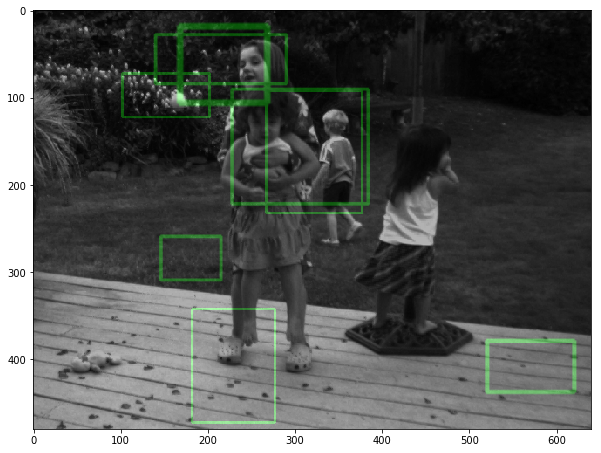

In [120]:
imageLoc = '../eval-data-gray/Backyard/'
imageSet = [imageLoc + str(image) for image in sorted(os.listdir(imageLoc))]
image = [cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB) for image in imageSet]
multiScaleObject(image, 25, mth = 2.5, orth = 180, scaleset = [0.3,0.4,0.6,0.8,1], minw = None, minh = None, maxsc = 0.3)

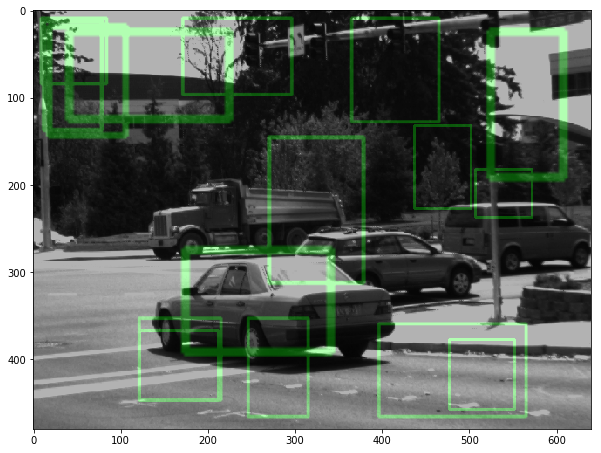

In [121]:
imageLoc = '../eval-data-gray/Dumptruck/'
imageSet = [imageLoc + str(image) for image in sorted(os.listdir(imageLoc))]
image = [cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB) for image in imageSet]
multiScaleObject(image,25,mth=2.5,orth=180,scaleset=[0.3,0.4,0.6,0.8,1],minw=None,minh=None,maxsc=0.3)

In [17]:
FRAME_WRITE_RATE = 25
PATH_TO_OUTPUT_VIDEO = "./traffic_detection.mp4"

imageLoc = './traffic_detection_frames/'
imageSet = [imageLoc + str(image) for image in sorted(os.listdir(imageLoc))]
rgbImageSet = [cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB) for image in imageSet]

In [20]:
vid = None
for i in range(len(rgbImageSet)-1):
    print (i, end=" ")
    if not vid:
        height, width, layers = rgbImageSet[0].shape
        frame_dims = (width, height)
        vid = cv2.VideoWriter(PATH_TO_OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'XVID'), FRAME_WRITE_RATE, frame_dims)
    objImg = movingObjectDetection([rgbImageSet[i], rgbImageSet[i+1]], 15, mth=2, orth=180, minw=None, minh=None, maxsc=0.3)
    vid.write(objImg)
vid.release()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

#### Object Detection OUtput Video:<br>
https://drive.google.com/file/d/19_wQra-T6hMINGHz7Y_eTORh3pflzND-/view?usp=sharing

### Tracking with LK

In [41]:
video = cv2.VideoCapture('./traffic.mp4')
PATH_TO_OUTPUT_VIDEO = "./tracking_traffic.mp4"
goodPointsTracks(video, 31, tpoints = 10, mth = 0.05, PATH_TO_OUTPUT_VIDEO=PATH_TO_OUTPUT_VIDEO)


array([[[ 39,  49,  48],
        [ 51,  61,  60],
        [ 51,  61,  60],
        ...,
        [ 51,  79,  77],
        [ 60,  88,  86],
        [ 54,  82,  80]],

       [[ 51,  61,  60],
        [ 39,  49,  48],
        [ 39,  49,  48],
        ...,
        [ 46,  74,  72],
        [ 57,  85,  83],
        [ 64,  92,  90]],

       [[ 51,  61,  60],
        [ 39,  49,  48],
        [ 39,  49,  48],
        ...,
        [ 51,  79,  77],
        [ 49,  77,  75],
        [ 62,  90,  88]],

       ...,

       [[120, 112, 107],
        [120, 112, 107],
        [120, 112, 107],
        ...,
        [135, 138, 151],
        [135, 138, 151],
        [136, 139, 152]],

       [[120, 112, 107],
        [120, 112, 107],
        [120, 112, 107],
        ...,
        [135, 138, 151],
        [135, 138, 151],
        [135, 138, 151]],

       [[120, 112, 107],
        [120, 112, 107],
        [120, 112, 107],
        ...,
        [133, 136, 149],
        [135, 138, 151],
        [135, 138, 151]]

#### Object Tracking Input Video:<br>
https://drive.google.com/file/d/1hQ-2Pi-xk6e1yjlovc6PMaOXaiLaJtf2/view?usp=sharing

#### Object Tracking Output Video:<br>
https://drive.google.com/file/d/1b7QHbbJxvMzjlJX1tphRqtt0-joLe7rH/view?usp=sharing